In [2]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
plt.rcParams["svg.fonttype"] = "none"  # Ensures the text is not converted to paths
from sklearn.model_selection import train_test_split
import shap
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, GRU, LayerNormalization, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from matplotlib.colors import Normalize
from tensorflow.keras.regularizers import l1, l1_l2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.utils import to_categorical
from itertools import product
from matplotlib.legend_handler import HandlerBase
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.patches import Patch, PathPatch
from matplotlib.patches import Rectangle
from matplotlib.path import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import itertools
import numpy as np
import matplotlib.gridspec as gridspec

In [3]:
def get_column_order(file_name):
    config = {'sequence_column_name': None, 'signal_column_name': None}

    data = [['sequence'], 
            ['global_iclip']  ,  
            ['m6a']  ,   
            ['paris_intramol'], 
            ['rnafold'], 
            ['paris_intergroup',  'paris_intragroup'],  
            ['AGO2_postar3' ,   'APC_postar3' ,    'CBP_postar3',     'CELF_postar3'  ,  'CELF1_postar3' ,   'CELF2_postar3' ,  'CELF4_postar3' ,  'CIRBP_postar3' ,  'CPSF6_postar3' ,  'CREBBP_postar3' , 'ELAVL1_postar3',  'EZH2_postar3','FAM120A_postar3', 'FMR1_postar3' ,   'FUS_postar3'  ,   'HNRNPR_postar3',  'LIN28A_postar3' , 'MBNL1_postar3'  ,  'MBNL2_postar3' ,  'MBNL3_postar3' ,  'MSI2_postar3'   , 'NOVA1_postar3' ,  'NOVA2_postar3'  , 'PABPC1_postar3' , 'POU5F1_postar3' , 'PTBP1_postar3'  , 'PTBP2_postar3'  , 'RBFOX1_postar3'  ,'RBFOX2_postar3' , 'RBFOX3_postar3'  ,'RBM10_postar3' ,  'RBM3_postar3'   ,  'SRRM4_postar3' ,  'SRSF1_postar3' ,  'SRSF2_postar3' ,  'SRSF3_postar3'  , 'SRSF4_postar3' ,  'SRSF7_postar3' ,  'TAF15_postar3'   ,'TARDBP_postar3' , 'TTP_postar3'   ,  'U2AF2_postar3'  , 'UPF1_postar3'  ,  'YTHDC2_postar3' , 'YY1_postar3'    ,  'ZFP36_postar3']]

    def powerset(iterable):
        s = list(iterable)
        return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

    powerset_result = list(powerset(data))

    for subset in powerset_result[1:]:
        config.update({'signal_column_name': None, 'sequence_column_name': None})
        signal_list = [sublist for sublist in subset if 'sequence' not in sublist]
        
        if any('sequence' in sublist for sublist in subset):
            config['sequence_column_name'] = 'sequence'
        
        signal_list_flat = [item for sublist in signal_list for item in sublist]
        config['signal_column_name'] = signal_list_flat if signal_list_flat else None

        merged_str = ""
        if config['sequence_column_name'] is not None:
            merged_str = f"{config['sequence_column_name']}:"        
        if config['signal_column_name'] is not None:
            signal_columns = config['signal_column_name']
            if any("postar" in s for s in signal_columns):
                signal_columns = [s for s in signal_columns if "postar" not in s]
                signal_columns.append("postar3")
                
            merged_str += ":".join(signal_columns)
        if merged_str == file_name:
            if config['sequence_column_name'] is not None and config['signal_column_name'] is not None:
                return ['A', 'C', 'G', 'T'] + config['signal_column_name'], config
            elif config['sequence_column_name'] is not None and config['signal_column_name'] is None:
                return ['A', 'C', 'G', 'T'], config
            else:
                return config['signal_column_name'], config

In [4]:
def bin_and_average(data, num_bins):
    subarrays = np.array_split(data, num_bins, axis=0)
    
    means = [np.nanmean(subarray, axis=0) for subarray in subarrays]
    
    binned_data = np.vstack(means)
    
    return binned_data

def bin_and_average_parts(data, lengths, num_bins=[10,50,50]):

    len_5, len_cds, len_3 = lengths
    total_length = data.shape[0]

    if len_5 + len_cds + len_3 != total_length:
        len_3 = total_length - len_5 - len_cds

    indices = np.cumsum([0, len_5, len_cds, len_3])
    parts = []
    for i in range(3):
        start = int(indices[i])
        end = int(indices[i+1])
        part = data[start:end]
        binned_part = bin_and_average(part, num_bins[i])
        parts.append(binned_part)

    result = np.concatenate(parts, axis=0)
    return result

In [5]:
def draw_importance_scores_values(shap_values, feature_names, tick_every=200, sum_postar=True, postar_size_ratio=6, cluster="None", index=None):

    sequence_column_name = "sequence"
    postar_indices = [i for i, name in enumerate(feature_names) if 'POSTAR3' in name]
    non_postar_indices = [i for i in range(len(feature_names)) if i not in postar_indices]

    sequence_indices = list(range(4))
    sequence_feature_names = [feature_names[i] for i in sequence_indices]
    
    if sum_postar:
        if postar_indices:
            postar_sum = np.sum(shap_values[:, postar_indices], axis=1)
        
            shap_values_non_postar = shap_values[:, non_postar_indices]
            shap_values = np.hstack((shap_values_non_postar, postar_sum[:, np.newaxis]))
        
            feature_names = [feature_names[i] for i in non_postar_indices] + ['POSTAR3 Sum']
        signal_column_names = feature_names[4:]
        num_postar_signals = 1 if postar_indices else 0
    else:
        signal_column_names = [feature_names[i] for i in non_postar_indices[4:]]  
        postar_signal_names = [feature_names[i] for i in postar_indices]
        signal_column_names += postar_signal_names
        shap_values_signals = np.hstack((shap_values[:, non_postar_indices[4:]], shap_values[:, postar_indices]))
        num_postar_signals = len(postar_indices)
    
    colors = ["#F2E5A9", "#A7D6AC", "#96BCD9", "#E8CADE"]
    nucleotide_mapping = ['A', 'C', 'G', 'U']
        
    absolute_max_value = np.percentile(np.abs(shap_values[:, :4]), 99.9) 
    
    sequence_length = shap_values.shape[0]
    tick_positions = np.arange(0, sequence_length, tick_every)
    tick_labels = [str(pos) for pos in tick_positions]
    
    num_signals = len(signal_column_names) - num_postar_signals
    total_rows = num_signals + (1 if num_postar_signals > 0 else 0) + 1 
    
    height_ratios = [4] + [1]*num_signals
    if num_postar_signals > 0:
        height_ratios += [postar_size_ratio]
    fig_height = sum(height_ratios)
    fig = plt.figure(figsize=(16, fig_height))
    gs = gridspec.GridSpec(nrows=total_rows, ncols=2, width_ratios=[50, 2], height_ratios=height_ratios)
    
    ax_sequence = fig.add_subplot(gs[0, :])
    for idx in range(4):
        ax_sequence.plot(range(sequence_length), shap_values[:, idx], color=colors[idx], label=f'{nucleotide_mapping[idx]}', alpha=0.6)
    
    ax_sequence.set_xlim(0, sequence_length)
    ax_sequence.set_ylim(-absolute_max_value, absolute_max_value) 
    ax_sequence.set_xlabel('Sequence position', fontsize=16)
    ax_sequence.set_ylabel('Importance Score', fontsize=16)
    if cluster:
        ax_sequence.set_title(f'Importance Scores over Sequence {index} for cluster {cluster}', fontsize=16)
    else:
        ax_sequence.set_title(f'Importance Scores over Sequence {index}', fontsize=16)
    ax_sequence.legend(nucleotide_mapping, loc='upper left')
    ax_sequence.set_xticks(tick_positions)
    ax_sequence.set_xticklabels(tick_labels)
    plt.setp(ax_sequence.get_xticklabels(), rotation=45)
    
    colors_cmap = ['#99E2FF', '#EFEFF0', '#C08CC6']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors_cmap, N=256)
    
    current_row = 1  
    if sum_postar:
        signal_data = shap_values[:, 4:]
    else:
        signal_data = shap_values_signals

    for i in range(num_signals):
        ax_heatmap = fig.add_subplot(gs[current_row, 0])
        ax_cbar = fig.add_subplot(gs[current_row, 1])

        signal_name = signal_column_names[i]
        signal_values = signal_data[:, i].reshape(1, -1)

        absolute_max_value = np.percentile(np.abs(signal_values), 99.9)

        sns.heatmap(signal_values, cmap=cmap, cbar=True, ax=ax_heatmap, cbar_ax=ax_cbar, yticklabels=[signal_name], annot=False, vmin=-absolute_max_value, vmax=absolute_max_value)

        ax_heatmap.set_xticks(tick_positions)
        ax_heatmap.set_xticklabels(tick_labels)
        plt.setp(ax_heatmap.get_xticklabels(), rotation=45)

        if num_postar_signals == 0 and i == num_signals - 1:
            ax_heatmap.set_xlabel('Sequence position (bp)', fontsize=16)
        else:
            ax_heatmap.set_xticklabels([])
            ax_heatmap.set_xlabel('')

        current_row += 1 
    
    if num_postar_signals > 0:
        ax_postar_heatmap = fig.add_subplot(gs[current_row, 0])
        ax_postar_cbar = fig.add_subplot(gs[current_row, 1])

        postar_data = signal_data[:, num_signals:].T 

        absolute_max_value = np.percentile(np.abs(postar_data), 99.9)

        sns.heatmap(postar_data, cmap=cmap, cbar=True, ax=ax_postar_heatmap, cbar_ax=ax_postar_cbar, yticklabels=postar_signal_names, annot=False, vmin=-absolute_max_value, vmax=absolute_max_value)

        ax_postar_heatmap.set_xticks(tick_positions)
        ax_postar_heatmap.set_xticklabels(tick_labels)
        plt.setp(ax_postar_heatmap.get_xticklabels(), rotation=45)

        ax_postar_heatmap.set_xlabel('Sequence position (bp)', fontsize=16)
        ax_postar_heatmap.set_ylabel('POSTAR3 Signals', fontsize=16)
    plt.tight_layout()

    plt.show()


In [6]:
def create_full_array(df, column_name):
    arrays_list = df[column_name].tolist()

    combined_array = np.stack(arrays_list, axis=0)

    return combined_array

def plot_sorted_array_with_top_bottom_colored(array, names):
    means = np.nanmean(array, axis=0)
    
    sorted_indices = np.argsort(means)
    sorted_array = array[:, sorted_indices]
    sorted_names = [names[i] for i in sorted_indices]
    
    x = np.arange(array.shape[0])
    
    plt.figure(figsize=(10, 6))
    
    for i in range(array.shape[1]):
        plt.plot(x, sorted_array[:, i], color='grey', alpha=0.1, linewidth=0.5)
    
    cmap = plt.get_cmap("coolwarm")
    top_5_indices = sorted_indices[-5:]
    bottom_5_indices = sorted_indices[:5]
    
    for i, idx in enumerate(top_5_indices):
        plt.plot(x, sorted_array[:, -5 + i], color=cmap(i / 10), label=sorted_names[-5 + i], linewidth=0.5)
        plt.text(100, sorted_array[-1, -5 + i], sorted_names[-5 + i], 
                 verticalalignment='bottom', horizontalalignment='right')
    
    for i, idx in enumerate(bottom_5_indices):
        plt.plot(x, sorted_array[:, i], color=cmap(i / 10), label=sorted_names[i], linewidth=0.5)
        plt.text(100, sorted_array[-1, i], sorted_names[i], 
                 verticalalignment='bottom', horizontalalignment='right')
    
    plt.xlabel("X (Index)")
    plt.ylabel("Y (Values)")
    plt.title("Sorted Array with Top and Bottom 5 Lines Highlighted")
    plt.show()
    plt.tight_layout()
    plt.close()


def average_and_plot_heatmap(data, feature_names, num_ticks=10, sum_postar=False, sum_length_dim=False, cluster=False, max_abs=None, num_bins_for_parts=None, plot_all_together=False):
    print(feature_names)
    if data.shape[2] != len(feature_names):
        raise ValueError("Length of feature_names must match the number of features in data.")

    averaged_data = np.nanmean(data, axis=0)
    
    postar_indices = [i for i, name in enumerate(feature_names) if 'POSTAR3' in name]

    if sum_postar:
        
        print("Printing postar indices")
        print(postar_indices)
        non_postar_indices = [i for i in range(len(feature_names)) if i not in postar_indices]

        if postar_indices:
            postar_sum = np.sum(averaged_data[:, postar_indices], axis=1)

            averaged_data = np.hstack((averaged_data[:, non_postar_indices], postar_sum[:, np.newaxis]))

            feature_names = [feature_names[i] for i in non_postar_indices] + ['Postar Sum']
        else:
            pass

    if sum_length_dim:
        averaged_data = np.nanmean(averaged_data, axis=0).reshape(1, -1)

        averaged_data_list = [i for i in averaged_data[0, :]]

        combined = list(zip(averaged_data_list, feature_names))

        filtered_combined = [(value, label) for value, label in combined if 'POSTAR3' in label]

        combined_sorted = sorted(filtered_combined, key=lambda x: x[0], reverse=True)

        sorted_top_array, feature_names = zip(*combined_sorted)

        averaged_data = np.array(sorted_top_array).reshape(1, -1)

    if not max_abs:
        max_abs = np.abs(averaged_data).max()

    colors = ['#99E2FF', '#EFEFF0', '#C08CC6']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    num_features = data.shape[2]

    if sum_postar and postar_indices:
        num_features = num_features - len(postar_indices) + 1

    figure_height = num_features / 2.5
    figure_length = 18 if not sum_length_dim else 1
    print(figure_height, figure_length)

    print(averaged_data.shape)
    
    if plot_all_together:
        plt.figure(figsize=(figure_length, figure_height))

        ax = sns.heatmap(averaged_data.T, cmap=cmap, yticklabels=feature_names,
                    vmin=-max_abs, vmax=max_abs)
        
        length = averaged_data.shape[0]

        tick_positions = np.linspace(0, length , num=num_ticks+1)
        tick_labels = [f'{int(pos)}' for pos in tick_positions]

        if "AGO2 POSTAR3" in feature_names:
            feature_names = [name for name in feature_names if "POSTAR3" not in name]
            feature_names.append("POSTAR3")

        if num_bins_for_parts:
            position = 0
            for i in range(len(num_bins_for_parts)-1):
                position += num_bins_for_parts[i]
                plt.axvline(x=position, color='black', linestyle='--')


        plt.xlabel('Relative Length', fontsize=14)
        plt.ylabel('Features', fontsize=14)

        plt.xlim(0, length+1)
        if cluster is False:
            plt.title(f'Averaged Data Heatmap for {", ".join(feature_names[:5])} and...', fontsize=16)
        else:    
            plt.title(f'Averaged Data Heatmap for {", ".join(feature_names[:5])} and... for Cluster {cluster}', fontsize=16)

        plt.show()
        
    else:
        first_4_data = averaged_data[:, :4].T
        first_4_features = feature_names[:4]

        individual_data = [averaged_data[:, i].reshape(1, -1) for i in range(4, averaged_data.shape[1])]
        individual_features = [feature_names[i] for i in range(4, averaged_data.shape[1])]

        num_subplots = 4
        if sum_postar:
            fig, axs = plt.subplots(
            nrows=num_subplots, 
            figsize=(figure_length, figure_height*2.5), 
            gridspec_kw={'height_ratios': [2.5, 0.6, 0.6, 0.6]},
            sharex=True
            )
        else:
            fig, axs = plt.subplots(
                nrows=num_subplots, 
                figsize=(figure_length, figure_height), 
                gridspec_kw={'height_ratios': [2.5, 0.6, 0.6, 10]},
                sharex=True
            )

        length = averaged_data.shape[0]
        tick_positions = np.linspace(0, length, num=num_ticks + 1)
        tick_labels = [f'{int(pos)}' for pos in tick_positions]
        max_abs = np.abs(first_4_data).max()

        sns.heatmap(
            first_4_data,
            ax=axs[0],
            cmap=cmap,
            yticklabels=first_4_features,
            vmin=-max_abs,
            vmax=max_abs,
            cbar_kws={'label': 'Intensity'}
        )
        axs[0].yaxis.set_tick_params(labelrotation=0)
        if num_bins_for_parts:
            position = 0
            for z in range(len(num_bins_for_parts)-1):
                position += num_bins_for_parts[z]
                axs[0].axvline(x=position, color='black', linestyle='--')

        for i in range(3):
            if i != 2:
                data_i = individual_data[i]
                feature_name = [individual_features[i]] 
                max_abs = np.abs(data_i).max()
            else:
                data_i = individual_data[i:]
                data_i = np.vstack(data_i)
                print(data_i.shape)
                feature_name = [individual_features[i:]][0] 
                print(feature_name[0])
                max_abs = np.abs(data_i).max()

            sns.heatmap(
                data_i,
                ax=axs[i + 1],
                cmap=cmap, 
                yticklabels=feature_name,
                vmin=-max_abs,
                vmax=max_abs,
                cbar_kws={'label': 'Intensity'}
            )
            axs[i + 1].yaxis.set_tick_params(labelrotation=0)  

            if i == 2:
                axs[i + 1].set_xticks(tick_positions)
                axs[i + 1].set_xticklabels(tick_labels, rotation=0)
                axs[i + 1].set_xlabel('Relative Length', fontsize=14)
            if num_bins_for_parts:
                position = 0
                for z in range(len(num_bins_for_parts)-1):
                    position += num_bins_for_parts[z]
                    axs[i + 1].axvline(x=position, color='black', linestyle='--')
        plt.tight_layout()

        plt.show()

In [7]:

def clean_column_names(columns):

    custom_dict = {
        'sequence': 'Sequence',
        'global_iclip': 'Global iCLIP',
        'm6a': 'm6A',
        'paris_intramol': 'PARIS Intramolecular',
        'paris_intergroup': 'PARIS Intergroup',
        'paris_intragroup': 'PARIS Intragroup',
        'rnafold': 'RNAfold',
    }

    cleaned_columns = []
    
    for col in columns:
        if col in custom_dict:
            cleaned_columns.append(custom_dict[col])
        elif '_postar3' in col:
            protein, _ = col.split('_postar3')
            cleaned_columns.append(f'{protein.upper()} POSTAR3')
        else:
            cleaned_columns.append(col.capitalize())
    
    return cleaned_columns

In [8]:
def mean_by_length(arr):
    return np.nanmean(arr, axis=0).tolist()


def plot_violin_and_summed_column(df, column_name, feature_names):

    data = df[column_name].tolist()

    expanded_df = pd.DataFrame(data, columns=feature_names)

    if "AGO2 POSTAR3" in feature_names:
        postar_columns = [col for col in feature_names if 'POSTAR3' in col]
        expanded_df['Sum_POSTAR3'] = expanded_df[postar_columns].sum(axis=1)
        expanded_df.drop(columns=postar_columns, inplace=True)
        feature_names = [name for name in feature_names if "POSTAR3" not in name]
        feature_names.append("Sum_POSTAR3")

    expanded_df['sum_of_features'] = expanded_df.sum(axis=1)

    plt.figure(figsize=(len(feature_names), 4))
    if feature_names != []:
        plt.violinplot([expanded_df[feature] for feature in feature_names], showmeans=True)
        
    if "Sum_POSTAR3" in expanded_df.columns:
        plt.violinplot([expanded_df['Sum_POSTAR3']], showmeans=True, positions=[len(feature_names)])

    plt.violinplot([expanded_df['sum_of_features']], showmeans=True, positions=[len(feature_names) + 1])

    plt.xticks(ticks=range(1, len(feature_names) + 2), labels=feature_names + ['Summed Features'], rotation=45)

    plt.title('Violin Plot for Each Feature and Averaged Features')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.grid(False)
    sns.despine()

    plt.show()


In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding
from sklearn.decomposition import PCA, FactorAnalysis,  DictionaryLearning, NMF
import umap.umap_ as umap

def dimensionality_reduction(pivot_df, type_of_reduction, umap_metric):
    if type_of_reduction == 'TSNE':
        tsne = TSNE(n_components=2)
        data_reduced = tsne.fit_transform(pivot_df)
    if type_of_reduction == 'UMAP':
        reducer = umap.UMAP(n_components=2, metric=umap_metric)
        data_reduced = reducer.fit_transform(pivot_df)
    if type_of_reduction == 'PCA':
        pca = PCA(n_components=2)
        data_reduced = pca.fit_transform(pivot_df)
    if type_of_reduction == 'Isomap':
        isomap = Isomap(n_components=2)
        data_reduced = isomap.fit_transform(pivot_df)
    if type_of_reduction == 'Multidimensional scaling':
        mds = MDS(n_components=2)
        data_reduced = mds.fit_transform(pivot_df)
    if type_of_reduction == 'Spectral Embedding':
        spectral_embedding = SpectralEmbedding(n_components=2)
        data_reduced = spectral_embedding.fit_transform(pivot_df)
    if type_of_reduction == 'Factor Analysis':
        factor_analysis = FactorAnalysis(n_components=2)
        data_reduced = factor_analysis.fit_transform(pivot_df)
    if type_of_reduction == 'Dictionary Learning':
        dict_learning = DictionaryLearning(n_components=2)
        data_reduced = dict_learning.fit_transform(pivot_df)
        
    return data_reduced

def cluster_the_data(data, n_clusters, type_of_clustering):
    if type_of_clustering == 'KMeans':
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
    else:
        aggclust = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = aggclust.fit_predict(data)
    return cluster_labels

def plot_scatter_of_components(reduced_data, type_of_reduction, n_clusters, cluster_labels, type_of_clustering, umap_metric):
    colors = ['#99E2FF', '#EFEFF0', '#C08CC6']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap=cmap, s=10, alpha=0.5)
    plt.title(f'{type_of_reduction} Scatterplot with {n_clusters} Clusters by {type_of_clustering}:{umap_metric}', fontsize=16)
    plt.xlabel(f'{type_of_reduction} Component 1', fontsize=14)
    plt.ylabel(f'{type_of_reduction} Component 2', fontsize=14)
    plt.legend(*scatter.legend_elements(), title="Clusters")

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'Results/Figure_II/umap_clustering.svg', bbox_inches='tight')

    plt.show()    

def process_and_cluster(df, column_name, n_clusters=3, type_of_reduction='PCA', plot=True, umap_metric='euclidean', type_of_clustering='KMeans'):

    arrays = np.stack(df[column_name].values, axis=0)
    print("arrays_before_flatten", arrays.shape)

    arrays = arrays.reshape(arrays.shape[0], -1)
    print("arrays_after_flatten", arrays.shape)

    reduced_data = dimensionality_reduction(arrays, type_of_reduction, umap_metric)
    print("reduced_data", reduced_data.shape)
    cluster_labels = cluster_the_data(reduced_data, n_clusters, type_of_clustering)

    plot_scatter_of_components(reduced_data, type_of_reduction, n_clusters, cluster_labels, type_of_clustering, umap_metric) if plot else None
        
    df[f'Cluster'] = cluster_labels

    return df

In [10]:
def concatenate_arrays_across_dfs(results, datasets_to_join, array_column_name="Contribution_Scores_for_Group_True"):
    
    standardised_arrays = []
    non_standardised_arrays = []
    all_array_names = []
    scaler = StandardScaler()

    for i, key in enumerate(datasets_to_join):
        print(key)
        df, array_names  = results[key]

        if i == 0:
            first_arrays = df[array_column_name].tolist()
            standardized_first_arrays = [scaler.fit_transform(arr) for arr in first_arrays]


            standardised_arrays = standardized_first_arrays
            non_standardised_arrays = first_arrays
        else:
            new_arrays = df[array_column_name].tolist()
            
            standardized_new_arrays = [scaler.fit_transform(arr) for arr in new_arrays]

            standardised_arrays = [np.concatenate((standardised_arrays[j], standardized_new_arrays[j]), axis=1) 
                                   for j in range(len(standardised_arrays))]
            
            non_standardised_arrays = [np.concatenate((non_standardised_arrays[j], new_arrays[j]), axis=1) 
                                   for j in range(len(non_standardised_arrays))]
            print(non_standardised_arrays[0].shape)

        all_array_names.append(array_names)
        
    df_new = df.drop(columns=[array_column_name])
    df_new[array_column_name] = non_standardised_arrays
    df_new[f'Standardised_{array_column_name}'] = standardised_arrays
    return df_new, all_array_names

In [11]:
def sum_and_drop_postar_columns(df):

    postar_columns = [col for col in df.columns if 'POSTAR3' in col]
    
    df['POSTAR3_Sum'] = df[postar_columns].sum(axis=1)
    
    df = df.drop(columns=postar_columns)
    
    return df

def plot_feature_correlations(df, array_column_name, feature_names, sum_postar=False, max_abs=None):

    arrays = np.vstack(df[array_column_name].values)
    print(arrays.shape)

    combined_df = pd.DataFrame(arrays, columns=feature_names)


    if "AGO2 POSTAR3" in feature_names and sum_postar:
        combined_df = sum_and_drop_postar_columns(combined_df)

        feature_names = [name for name in feature_names if "POSTAR3" not in name]
        feature_names.append("POSTAR3_Sum")
   
    log_transformed_df = np.log(combined_df)

    plot_scatter = False
    if plot_scatter:
        for feature1, feature2 in itertools.combinations(feature_names, 2):
            if ("Global iCLIP" != feature1 and "Global iCLIP" != feature2) or ("G" != feature1 and "G" != feature2):
                continue
            plt.figure(figsize=(6, 6))
            plt.scatter(log_transformed_df[feature1], log_transformed_df[feature2], alpha=0.5, s=10)
            plt.xlabel(feature1)
            plt.ylabel(feature2)
            plt.title(f'{feature1} vs {feature2}')

            plt.show()

            print(f'Correlation coefficient between {feature1} and {feature2}:', np.log(log_transformed_df[feature1]).corr(np.log(log_transformed_df[feature2]), method='pearson'))
            break

    correlation_matrix = combined_df.corr(method="pearson")
    print(correlation_matrix.shape)
    np.fill_diagonal(correlation_matrix.values, np.nan)

    feature_names_no_postar = feature_names

    feature_names_nucleotides = [name for name in feature_names_no_postar if len(name) == 1]
    feature_names_nucleotides_indices = [feature_names.index(col) for col in feature_names_nucleotides]   
    correlation_matrix.iloc[feature_names_nucleotides_indices, feature_names_nucleotides_indices] = np.nan
    if "AGO2 POSTAR3" in feature_names and not sum_postar:
        postar_columns = [col for col in feature_names if 'POSTAR3' in col]
        postar_indices = [feature_names.index(col) for col in postar_columns]
        correlation_matrix.iloc[postar_indices, postar_indices] = np.nan
        correlation_matrix = correlation_matrix.drop(index=postar_columns)
        good_postar_columns = ['SRSF3 POSTAR3', 'POU5F1 POSTAR3','SRRM4 POSTAR3', 'AGO2 POSTAR3', 'FUS POSTAR3']
        good_postar_columns = [col for col in postar_columns if col not in good_postar_columns]
        correlation_matrix = correlation_matrix.drop(columns=good_postar_columns)
        feature_names_no_postar = [name for name in feature_names if "POSTAR3" not in name]
        feature_names_no_postar = [name for name in feature_names_no_postar if name not in good_postar_columns]
        feature_names = [name for name in feature_names if name not in good_postar_columns]


    colors = ['#99E2FF', '#EFEFF0', '#C08CC6']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    if not max_abs:
        max_abs = np.abs(correlation_matrix.values[~np.isnan(correlation_matrix.values)]).max()
    print("True max:", np.abs(correlation_matrix.values[~np.isnan(correlation_matrix.values)]).max())

    plt.figure(figsize=(6, 2.6))

    sns.heatmap(correlation_matrix, cmap=cmap, linewidths=0.5, annot=False, vmin=-max_abs, vmax=max_abs)
    plt.xticks(ticks=np.arange(len(feature_names)) + 0.5, labels=feature_names, fontsize=8, rotation=90)
    plt.yticks(ticks=np.arange(len(feature_names_no_postar)) + 0.5, labels=feature_names_no_postar, fontsize=8)
    plt.title('Feature Correlation Heatmap')
    
    plt.show()


In [12]:
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

def get_std_max_abs_of_column(df, column_name):
    arrays = df[column_name].tolist()
    arrays = np.vstack(arrays)
    std = np.std(arrays)
    abs_max = np.max(np.abs(arrays))
    return std, abs_max

def plot_pie_chart_of_gene_types(contribution_scores, cluster):

    unique_gene_types = contribution_scores["gene_type"].unique()

    color_list = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF6666', '#FFD700', '#8A2BE2', '#FF4500']

    gene_type_color_map = {gene_type: color_list[i % len(color_list)] for i, gene_type in enumerate(unique_gene_types)}

    def plot_cluster_pie(cluster):

        cluster_data = contribution_scores[contribution_scores["Cluster"] == cluster]["gene_type"].value_counts()

        cluster_colors = [gene_type_color_map[gene_type] for gene_type in cluster_data.index]


        plt.figure(figsize=(3, 3))
        wedges, tests, autotexts = plt.pie(cluster_data, colors=cluster_colors, startangle=90, autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.1)


        plt.legend(wedges, cluster_data.index, title="Gene Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

        plt.title(f"Gene Type Distribution for Cluster {cluster}")
        plt.axis('equal')  
        plt.show()
        
    plot_cluster_pie(cluster)
    
def plot_array_heatmap(df, column_name, feature_list, plotting_feature, max_length, std, max_abs, num_bins_for_parts=None):

    arrays = df[column_name].tolist()
    array_lengths = df["sequence_length"].tolist() 

    heatmap_df = pd.DataFrame(np.nan, index=range(len(arrays)), columns=range(max_length))


    for idx, array in enumerate(arrays):
        if array.shape[1] != len(feature_list):
            raise ValueError(f"Array at index {idx} does not match the feature list length.")

        try:
            feature_idx = feature_list.index(plotting_feature)
        except ValueError:
            raise ValueError(f"Plotting feature '{plotting_feature}' not found in feature list.")

        feature_values = array[:, feature_idx]

        heatmap_df.iloc[idx, :array.shape[0]] = feature_values

    heatmap_df['length'] = array_lengths
    heatmap_df.sort_values('length', inplace=True)
    heatmap_df.drop('length', axis=1, inplace=True)
    heatmap_df.reset_index(drop=True, inplace=True)

    print(max_abs)
    colors = ['#99E2FF', '#EFEFF0', '#C08CC6']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
    linthresh = np.percentile(np.abs(heatmap_df.values[~np.isnan(heatmap_df.values)]), 5)

    linthresh = std / 2

    print(linthresh)
    plt.figure(figsize=(12, 4))
    ax = sns.heatmap(heatmap_df, cmap=cmap, cbar=True, norm=SymLogNorm(linthresh=linthresh, linscale=1, vmin=-max_abs, vmax=max_abs))

    tick_positions = np.linspace(0, max_length, num=10)

    tick_labels = [f'{int(pos)}' for pos in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    
    if num_bins_for_parts:
        position = 0
        for i in range(len(num_bins_for_parts)-1):
            position += num_bins_for_parts[i]
            plt.axvline(x=position, color='black', linestyle='--')

    plt.xlabel('Absolute Nucleotide Positions')
    plt.ylabel('Trancripts')
    plt.title(f'Heatmap of {plotting_feature}')
    plt.show()


In [13]:
def smooth_array(arr, window_size=10):

    smoothed_array = np.zeros_like(arr)
    
    for i in range(arr.shape[1]):  

        smoothed_array[:, i] = np.convolve(arr[:, i], np.ones(window_size)/window_size, mode='same')
    
    return smoothed_array

def average_pooling(arr, window_size=10):

    output_length = (arr.shape[0] // window_size) + 1
    pooled_array = np.zeros((output_length, arr.shape[1]))
    

    for i in range(arr.shape[1]): 
        for j in range(output_length): 

            start = j * window_size
            end = start + window_size
            
            pooled_array[j, i] = np.nanmean(arr[start:end, i])
    
    return pooled_array

In [14]:
def plot_postar3_boxplots_colored(df, cluster=False, feature_keyword="POSTAR3", cmap_name='viridis'):

    postar3_columns = [col for col in df.columns if feature_keyword in col]

    column_means = df[postar3_columns].mean(skipna=True)

    sorted_columns = column_means.sort_values(ascending=False).index.tolist()
    max_abs = np.abs(column_means).max()

    norm = Normalize(vmin=-max_abs, vmax=max_abs)
    
    plt.figure(figsize=(8, 4)) 
    colors = ['#99E2FF', '#EFEFF0', '#C08CC6']
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    ax = sns.barplot(data=df[sorted_columns], palette=cmap(norm(column_means[sorted_columns])), orient='v')

    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    sorted_columns = [col.replace('POSTAR3', '') for col in sorted_columns]

    plt.title(f'Boxplots of Features with "{feature_keyword}",  {cluster}]', fontsize=16)
    
    plt.xticks(ticks=range(len(sorted_columns)), labels=sorted_columns, rotation=90 ,ha='right')
    plt.ylabel('Features', fontsize=14)
    plt.xlabel('Values', fontsize=14)
    
    plt.tight_layout()
    plt.show()

def average_features(df, name_of_column, feature_names, cluster=False):
    array_list = df[name_of_column].tolist()
    
    averaged_arrays = []
    
    for array in array_list:
        array = np.array(array)
        averaged_array = np.nanmean(array, axis=0)
        averaged_arrays.append(averaged_array)
    
    averaged_df = pd.DataFrame(averaged_arrays, columns=feature_names)
    plot_postar3_boxplots_colored(averaged_df, cluster=cluster)

In [15]:
def rolling_average_triplets(array):
    array = array[:, :4]

    length = array.shape[0]

    nucleotides = ['A', 'C', 'G', 'T']
    all_combinations = [''.join(comb) for comb in itertools.product(nucleotides, repeat=3)]
    nucleotide_to_index = {nucleotide: i for i, nucleotide in enumerate(nucleotides)}
    transformed_array = []
    
    transformed_array = np.zeros((length - 2, 64))

    for combination in all_combinations:
        for i in range(length - 2): 
            value_1 = array[i, nucleotide_to_index[combination[0]]] 
            value_2 = array[i+1, nucleotide_to_index[combination[1]]]
            value_3 = array[i+2, nucleotide_to_index[combination[2]]]

            mean_value = (value_1 + value_2 + value_3) / 3

            transformed_array[i, all_combinations.index(combination)] = mean_value
    
    return transformed_array

In [16]:
def one_hot_encode_sequence(sequence):
    nucleotides = 'ACGT'
    char_to_int = {char: idx for idx, char in enumerate(nucleotides)}
    num_classes = len(nucleotides)

    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = np.zeros((len(sequence), num_classes))
    onehot_encoded[np.arange(len(sequence)), integer_encoded] = 1
    return onehot_encoded

def process_row(row, column_name, present):
    importance_scores = np.array(row[column_name])    
    if present == "sequence:":
        signal = row["sequence"]
        present_encoded = one_hot_encode_sequence(signal)
    elif present == "postar3":
        all_arrays = []
        for postar in ['AGO2_POSTAR3', 'APC POSTAR3', 'CBP POSTAR3', 'CELF POSTAR3', 'CELF1 POSTAR3', 'CELF2 POSTAR3', 'CELF4 POSTAR3', 'CIRBP POSTAR3', 'CPSF6 POSTAR3', 'CREBBP POSTAR3', 'ELAVL1 POSTAR3', 'EZH2 POSTAR3', 'FAM120A POSTAR3', 'FMR1 POSTAR3', 'FUS POSTAR3', 'HNRNPR POSTAR3', 'LIN28A POSTAR3', 'MBNL1 POSTAR3', 'MBNL2 POSTAR3', 'MBNL3 POSTAR3', 'MSI2 POSTAR3', 'NOVA1 POSTAR3', 'NOVA2 POSTAR3', 'PABPC1 POSTAR3', 'POU5F1 POSTAR3', 'PTBP1 POSTAR3', 'PTBP2 POSTAR3', 'RBFOX1 POSTAR3', 'RBFOX2 POSTAR3', 'RBFOX3 POSTAR3', 'RBM10 POSTAR3', 'RBM3 POSTAR3', 'SRRM4 POSTAR3', 'SRSF1 POSTAR3', 'SRSF2 POSTAR3', 'SRSF3 POSTAR3', 'SRSF4 POSTAR3', 'SRSF7 POSTAR3', 'TAF15 POSTAR3', 'TARDBP POSTAR3', 'TTP POSTAR3', 'U2AF2 POSTAR3', 'UPF1 POSTAR3', 'YTHDC2 POSTAR3', 'YY1 POSTAR3', 'ZFP36 POSTAR3']:

            postar = row[postar].split(" ")[0] + "_postar3"
            signal = row[postar]
            signal_list = [float(x.strip()) for x in signal.split(',')]
            signal_array = np.array(signal_list)
            all_arrays.append(signal_array)
        present_encoded = np.stack(all_arrays, axis=1)
    elif present == "paris_intergroup:paris_intragroup":  
        all_arrays = []
        for paris_inter in ['paris_intergroup', 'paris_intragroup']:
            signal = row[paris_inter]
            signal_list = [float(x.strip()) for x in signal.split(',')]
            signal_array = np.array(signal_list)
            all_arrays.append(signal_array)
        present_encoded = np.stack(all_arrays, axis=1)
    else:
        signal = row[present]
        signal_list = [float(x.strip()) for x in signal.split(',')]
        present_encoded = np.array(signal_list)

    importance_scores = np.array(row[column_name])

    multiplied = importance_scores * present_encoded
    return multiplied

In [17]:
def normalize_row(arr):

    zero_count = np.sum(arr == 0, axis=0)
    non_zero_count = 1 - (zero_count / len(arr))
    norm_arr = arr / non_zero_count

    return norm_arr

def parse_array(array_str):
    return np.array([float(x) for x in array_str.split(',')])

def process_postar3_row(row):
    
    postar_arrays = [parse_array(row[col]) for col in postar_columns]
    
    postar_sums = np.sum(postar_arrays, axis=1)
    
    original_array = row['Contribution_Scores_for_Group_True']
    
    normalized_array = original_array / (postar_sums+1)
    
    return normalized_array

Processing results_rep3
arrays_before_flatten (1824, 100, 4)
arrays_after_flatten (1824, 400)
reduced_data (1824, 2)


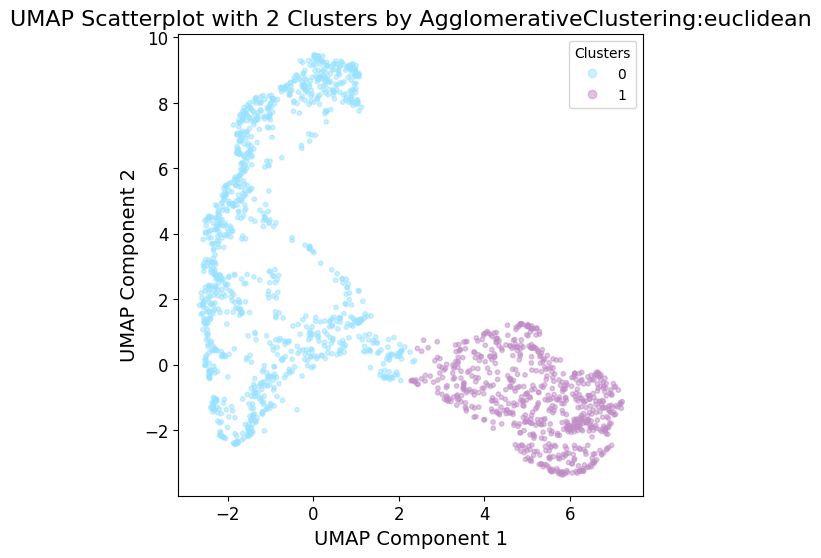

In [28]:
main_dirs = [
            "Final_Training_Run_ALL"
             ]

runs = [
        "training_run_28102024_135739362"
        ]

datasets = [
            'results_rep3'
            ]

smoops_type = [
               "smoops_common"
               ]

results = {}

for index in range(len(runs)):
    
    print(f"Processing {datasets[index]}")
    main_dir = f"Analysis/Exploratory/Model_Training/Models/{main_dirs[index]}/{runs[index]}"

    file_path = os.path.join(main_dir, datasets[index], "model_explanation/original_file_shuffled_with_contribution_scores_integrated_gradients.pkl")

    contribution_scores = pd.read_pickle(file_path)

    contribution_scores = contribution_scores[contribution_scores[smoops_type[index]] == True].reset_index(drop=True)

    num_of_bins = 100
    contribution_scores["Contribution_Scores_for_Group_True_Binned"] = contribution_scores["Contribution_Scores_for_Group_True"].apply(lambda x: bin_and_average(x, num_of_bins))
    contribution_scores = process_and_cluster(contribution_scores, 'Contribution_Scores_for_Group_True_Binned', n_clusters=2, type_of_reduction='UMAP', plot=True, umap_metric="euclidean", type_of_clustering='AgglomerativeClustering')

    contribution_scores = contribution_scores.groupby('transcript_id').first().reset_index()

    array_names = "sequence"

    results[datasets[index]] = contribution_scores, array_names

contribution_scores[["transcript_id", "Cluster"]].to_csv(f"Results/machine_learning_results/cluster_assignment_file/clusters_all_smoops_model.tsv", sep="\t", index=False)